In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

df = pd.read_csv("/content/cleaned_train1.csv")


# Features: drop original price and log_price
X = df.drop(columns=['price', 'log_price'])
y = df['log_price']  # use log-transformed price

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (12966, 20), Test shape: (3242, 20)


In [ ]:
# --- 2. DEFINE THE CONTENDERS ---
models = [
    LinearRegression(),
    Lasso(alpha=0.001),       # Small alpha prevents underfitting
    Ridge(alpha=1.0),         # Standard Ridge
    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42),
    xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1, random_state=42)
]

model_names = ["Linear Regression", "Lasso", "Ridge", "Random Forest", "XGBoost"]

# --- 3. THE BATTLE LOOP ---
print(f"{'MODEL':<20} | {'R² SCORE':<10} | {'RMSE ($)':<15}")
print("-" * 50)

results = {}

for name, model in zip(model_names, models):
    # Train
    model.fit(X_train, y_train)

    # Predict (Log Scale)
    log_preds = model.predict(X_test)

    # Inverse Transform (Real Dollars)
    actual_preds = np.expm1(log_preds)
    actual_y = np.expm1(y_test)

    # Evaluate
    r2 = r2_score(actual_y, actual_preds)
    mse = mean_squared_error(actual_y, actual_preds)
    rmse = np.sqrt(mse)

    # Save & Print
    results[name] = r2
    print(f"{name:<20} | {r2:.4f}     | ${rmse:,.0f}")

# --- 4. DECLARE WINNER ---
best_model = max(results, key=results.get)
print("-" * 50)
print(f"🏆 WINNER: {best_model} with R² = {results[best_model]:.4f}")

In [3]:
# Initialize XGBoost
xgb = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train the model
xgb.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [4]:
# Predict on train and test sets
y_train_pred_log = xgb.predict(X_train)
y_test_pred_log = xgb.predict(X_test)

# Convert back to original price scale
y_train_pred = np.expm1(y_train_pred_log)
y_test_pred = np.expm1(y_test_pred_log)
y_train_original = np.expm1(y_train)
y_test_original = np.expm1(y_test)


In [5]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# R²
train_r2 = r2_score(y_train_original, y_train_pred)
test_r2 = r2_score(y_test_original, y_test_pred)

# MAE
test_mae = mean_absolute_error(y_test_original, y_test_pred)

# RMSE
test_rmse = np.sqrt(mean_squared_error(y_test_original, y_test_pred))

print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MAE: ${test_mae:,.2f}")
print(f"Test RMSE: ${test_rmse:,.2f}")


Train R²: 0.9755
Test R²: 0.8938
Test MAE: $62,306.43
Test RMSE: $109,205.25


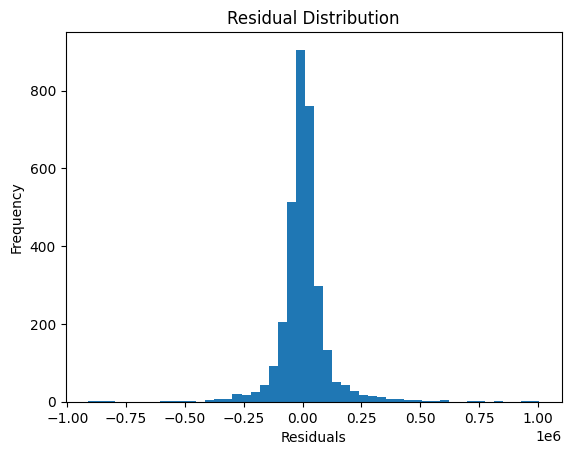

In [6]:
import matplotlib.pyplot as plt

residuals = y_test_original - y_test_pred
plt.hist(residuals, bins=50)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()


In [7]:
import shutil, os
from tqdm import tqdm

LOCAL_IMG_FOLDER = "/content/local_images"
DRIVE_IMG_FOLDER = "/content/drive/MyDrive/sat_img_train_data"

os.makedirs(LOCAL_IMG_FOLDER, exist_ok=True)

files = [f for f in os.listdir(DRIVE_IMG_FOLDER) if f.endswith('.jpg')]

for filename in tqdm(files):
    shutil.copy(os.path.join(DRIVE_IMG_FOLDER, filename),
                os.path.join(LOCAL_IMG_FOLDER, filename))


100%|██████████| 16208/16208 [06:13<00:00, 43.38it/s] 


In [8]:
df['image_path'] = df.index.map(lambda i: os.path.join(LOCAL_IMG_FOLDER, f"house_{i}.jpg"))


In [9]:
residual_train = y_train - y_train_pred_log
residual_test = y_test - y_test_pred_log


In [10]:
train_df = X_train.copy()
train_df['residual_log'] = residual_train.values
train_df['image_path'] = train_df.index.map(lambda i: os.path.join(LOCAL_IMG_FOLDER, f"house_{i}.jpg"))

test_df = X_test.copy()
test_df['residual_log'] = residual_test.values
test_df['image_path'] = test_df.index.map(lambda i: os.path.join(LOCAL_IMG_FOLDER, f"house_{i}.jpg"))

train_df.to_csv("train_residuals.csv", index=False)
test_df.to_csv("test_residuals.csv", index=False)


In [11]:
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class HouseImageDataset(Dataset):
    def __init__(self, csv_file, transform=None, residual_col='residual_log'):
        import pandas as pd
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.residual_col = residual_col

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        label = self.df.iloc[idx][self.residual_col]

        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (224,224))  # fallback black image

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)


In [12]:
from torchvision import transforms

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [13]:
from torch.utils.data import DataLoader

train_dataset = HouseImageDataset("train_residuals.csv", transform=image_transform)
test_dataset = HouseImageDataset("test_residuals.csv", transform=image_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


In [14]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResidualCNN(nn.Module):
    def __init__(self, fine_tune_last_block=True):
        super().__init__()
        # Load pretrained ResNet50
        self.base_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        # Replace final fully connected layer for regression
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 1)

        if fine_tune_last_block:
            # Freeze all layers first
            for param in self.base_model.parameters():
                param.requires_grad = False

            # Unfreeze last block + FC layer
            for param in self.base_model.layer4.parameters():
                param.requires_grad = True
            self.base_model.fc.requires_grad = True
        # else: full fine-tuning (all layers trainable)

    def forward(self, x):
        return self.base_model(x)


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResidualCNN(fine_tune_last_block=True).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 104MB/s]


In [16]:
from tqdm import tqdm
import torch
import torch.nn as nn

num_epochs = 20
patience = 5  # early stopping patience
best_test_loss = float('inf')
trigger_times = 0

# Optional: mixed precision
use_amp = True
scaler = torch.cuda.amp.GradScaler() if use_amp else None

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()

        if use_amp:
            with torch.cuda.amp.autocast():
                outputs = model(imgs).view(-1)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(imgs).view(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        loop.set_postfix(train_loss=loss.item())

    epoch_loss = running_loss / len(train_loader.dataset)

    # Evaluate on test set
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs).view(-1)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * imgs.size(0)
    test_loss /= len(test_loader.dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Early stopping
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        trigger_times = 0
        torch.save(model.state_dict(), "best_residual_cnn.pth")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break


/tmp/ipython-input-2359191321.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
Epoch 1/20:   0%|          | 0/406 [00:00<?, ?it/s]/tmp/ipython-input-2359191321.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/20] Train Loss: 0.0114, Test Loss: 0.0275


Epoch [2/20] Train Loss: 0.0048, Test Loss: 0.0294


Epoch [3/20] Train Loss: 0.0022, Test Loss: 0.0286


Epoch [4/20] Train Loss: 0.0017, Test Loss: 0.0287


Epoch [5/20] Train Loss: 0.0014, Test Loss: 0.0286


Epoch [6/20] Train Loss: 0.0014, Test Loss: 0.0284
Early stopping triggered at epoch 6


In [17]:
cnn_preds = []
model.eval()
with torch.no_grad():
    for imgs, _ in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs).squeeze().cpu().numpy()
        cnn_preds.extend(outputs)


In [19]:
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

final_log_price = y_test_pred_log + np.array(cnn_preds)
final_price = np.expm1(final_log_price)

r2 = r2_score(y_test_original, final_price)
mae = mean_absolute_error(y_test_original, final_price)
rmse = np.sqrt(mean_squared_error(y_test_original, final_price))

print(f"Combined XGB+CNN R2: {r2:.4f}")
print(f"MAE: ${mae:,.2f}")
print(f"RMSE: ${rmse:,.2f}")


Combined XGB+CNN R2: 0.8904
MAE: $65,122.48
RMSE: $110,950.35
